# Motivation and State of the Art
___

# Installing libraries
___

In [438]:
!pip install gensim --upgrade
!pip install tensorflow
!pip install numpy
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install nltk
!pip install seaborn
!pip install mlxtend
!pip install textblob

In [535]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
import re
import string
import tensorflow
from sklearn.metrics  import classification_report ,confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alexa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Get the data
___

In [536]:
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python")
data.columns = ["label", "id", "date", "query", "username", "text"]

In [537]:
data.head()

,label,id,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


Only the 'text' and 'label' columns are necessary.

In [538]:
data=data[['text','label']]

In [539]:
data.head()

,text,label
0,is upset that he can't update his Facebook by ...,0
1,@Kenichan I dived many times for the ball. Man...,0
2,my whole body feels itchy and like its on fire,0
3,"@nationwideclass no, it's not behaving at all....",0
4,@Kwesidei not the whole crew,0


In [540]:
data.columns

Index(['text', 'label'], dtype='object')

In [541]:
print('data length:', len(data))

data length: 1599999


In [542]:
data.shape

(1599999, 2)

In [543]:
data.info

<bound method DataFrame.info of                                                       text  label
0        is upset that he can't update his Facebook by ...      0
1        @Kenichan I dived many times for the ball. Man...      0
2          my whole body feels itchy and like its on fire       0
3        @nationwideclass no, it's not behaving at all....      0
4                            @Kwesidei not the whole crew       0
...                                                    ...    ...
1599994  Just woke up. Having no school is the best fee...      4
1599995  TheWDB.com - Very cool to hear old Walt interv...      4
1599996  Are you ready for your MoJo Makeover? Ask me f...      4
1599997  Happy 38th Birthday to my boo of alll time!!! ...      4
1599998  happy #charitytuesday @theNSPCC @SparksCharity...      4

[1599999 rows x 2 columns]>

In [544]:
data.dtypes

text     object
label     int64
dtype: object

Label '4' gets changed to label '1'.

In [545]:
data.loc[data['label']==4, 'label'] = 1

In [546]:
data.info

<bound method DataFrame.info of                                                       text  label
0        is upset that he can't update his Facebook by ...      0
1        @Kenichan I dived many times for the ball. Man...      0
2          my whole body feels itchy and like its on fire       0
3        @nationwideclass no, it's not behaving at all....      0
4                            @Kwesidei not the whole crew       0
...                                                    ...    ...
1599994  Just woke up. Having no school is the best fee...      1
1599995  TheWDB.com - Very cool to hear old Walt interv...      1
1599996  Are you ready for your MoJo Makeover? Ask me f...      1
1599997  Happy 38th Birthday to my boo of alll time!!! ...      1
1599998  happy #charitytuesday @theNSPCC @SparksCharity...      1

[1599999 rows x 2 columns]>

In [547]:
data["label"].value_counts()

label
1    800000
0    799999
Name: count, dtype: int64

In [548]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

## Dataset reduction for testing

In [549]:
data_pos = data_pos.iloc[:int(70000)]
data_neg = data_neg.iloc[:int(70000)]
data["label"].value_counts()

label
1    800000
0    799999
Name: count, dtype: int64

In [550]:
data = pd.concat([data_pos, data_neg])

# Text cleaning
___

In [551]:
data.info

<bound method DataFrame.info of                                                      text  label
799999       I LOVE @Health4UandPets u guys r the best!!       1
800000  im meeting up with one of my besties tonight! ...      1
800001  @DaRealSunisaKim Thanks for the Twitter add, S...      1
800002  Being sick can be really cheap when it hurts t...      1
800003    @LovesBrooklyn2 he has that effect on everyone       1
...                                                   ...    ...
69995                                            Wow....       0
69996   @Dainfam0uszd  NO UR NOT.....U R MY ONLY P.E.O...      0
69997   I will be so much happier when I don't have to...      0
69998   @mariancall buy it and bring it up here I woul...      0
69999   @jenniferrr_gee we haven't had it yet  he's 't...      0

[140000 rows x 2 columns]>

Abbreviations are changed to whole words.

In [552]:
chat_word = {
    'AFAIK': 'As Far As I Know',
    'AFK': 'Away From Keyboard',
    'ASAP': 'As Soon As Possible',
    'ATK': 'At The Keyboard',
    'ATM': 'At The Moment',
    'A3': 'Anytime, Anywhere, Anyplace',
    'BAK': 'Back At Keyboard',
    'BBL': 'Be Back Later',
    'BBS': 'Be Back Soon',
    'BFN': 'Bye For Now',
    'B4N': 'Bye For Now',
    'BRB': 'Be Right Back',
    'BRT': 'Be Right There',
    'BTW': 'By The Way',
    'B4': 'Before',
    'CU': 'See You',
    'CUL8R': 'See You Later',
    'CYA': 'See You',
    'FAQ': 'Frequently Asked Questions',
    'FC': 'Fingers Crossed',
    'FWIW': "For What It's Worth",
    'FYI': 'For Your Information',
    'GAL': 'Get A Life',
    'GG': 'Good Game',
    'GN': 'Good Night',
    'GMTA': 'Great Minds Think Alike',
    'GR8': 'Great!',
    'G9': 'Genius',
    'IC': 'I See',
    'ICQ': 'I Seek you (also a chat program)',
    'ILU': 'ILU: I Love You',
    'IMHO': 'In My Honest/Humble Opinion',
    'IMO': 'In My Opinion',
    'IOW': 'In Other Words',
    'IRL': 'In Real Life',
    'KISS': 'Keep It Simple, Stupid',
    'LDR': 'Long Distance Relationship',
    'LMAO': 'Laugh My A.. Off',
    'LOL': 'Laughing Out Loud',
    'LTNS': 'Long Time No See',
    'L8R': 'Later',
    'MTE': 'My Thoughts Exactly',
    'M8': 'Mate',
    'NRN': 'No Reply Necessary',
    'OIC': 'Oh I See',
    'PITA': 'Pain In The A..',
    'PRT': 'Party',
    'PRW': 'Parents Are Watching',
    'QPSA?': 'Que Pasa?',
    'ROFL': 'Rolling On The Floor Laughing',
    'ROFLOL': 'Rolling On The Floor Laughing Out Loud',
    'ROTFLMAO': 'Rolling On The Floor Laughing My A.. Off',
    'SK8': 'Skate',
    'STATS': 'Your sex and age',
    'ASL': 'Age, Sex, Location',
    'THX': 'Thank You',
    'TTFN': 'Ta-Ta For Now!',
    'TTYL': 'Talk To You Later',
    'R': 'ARE',
    'U': 'You',
    'U2': 'You Too',
    'U4E': 'Yours For Ever',
    'WB': 'Welcome Back',
    'WTF': 'What The F...',
    'WTG': 'Way To Go!',
    'WUF': 'Where Are You From?',
    'W8': 'Wait...',
    '7K': 'Sick:-D Laugher',
    'TFW': 'That feeling when',
    'MFW': 'My face when',
    'MRW': 'My reaction when',
    'IFYP': 'I feel your pain',
    'TNTL': 'Trying not to laugh',
    'JK': 'Just kidding',
    'IDC': "I don't care",
    'ILY': 'I love you',
    'IMU': 'I miss you',
    'ADIH': 'Another day in hell',
    'ZZZ': 'Sleeping, bored, tired',
    'WYWH': 'Wish you were here',
    'TIME': 'Tears in my eyes',
    'BAE': 'Before anyone else',
    'FIMH': 'Forever in my heart',
    'BSAAW': 'Big smile and a wink',
    'BWL': 'Bursting with laughter',
    'BFF': 'Best friends forever',
    'CSL': "Can't stop laughing"
}

In [553]:
def short_conv(text):
    new_text = []
    for w in text.split():
        if w.upper() in chat_word:
            new_text.append(chat_word[w.upper()])
        else:
            new_text.append(w)
    return " ".join(new_text)
data['text'] = data['text'].apply(lambda text: short_conv(text))
data['text'].head()

799999      I LOVE @Health4UandPets You guys ARE the best!!
800000    im meeting up with one of my besties tonight! ...
800001    @DaRealSunisaKim Thanks for the Twitter add, S...
800002    Being sick can be really cheap when it hurts t...
800003       @LovesBrooklyn2 he has that effect on everyone
Name: text, dtype: object

Spelling Correction

In [554]:
#data['text'] = data['text'].apply(lambda text: TextBlob(text).correct().string)

In [555]:
#data['text'].head()

LOWERCASE

In [556]:
data['text']=data['text'].str.lower()
data['text'].head()

799999      i love @health4uandpets you guys are the best!!
800000    im meeting up with one of my besties tonight! ...
800001    @darealsunisakim thanks for the twitter add, s...
800002    being sick can be really cheap when it hurts t...
800003       @lovesbrooklyn2 he has that effect on everyone
Name: text, dtype: object

In [557]:
stopwords_list = stopwords.words('english')
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [558]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                    love @health4uandpets guys best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

REMOVING USERNAME, URL, HASHTAGS and Non-Alphabets

In [559]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = r"@[^\s]+"
hastagPattern = r"#[^\s]+"
alphaPattern = r"[^a-zA-Z]"

In [560]:
data['text'] = data['text'].apply(lambda text: re.sub(userPattern,'', text))
data['text'] = data['text'].apply(lambda text: re.sub(hastagPattern,'',text))
data['text'] = data['text'].apply(lambda text: re.sub(urlPattern,'',text))
data['text'] = data['text'].apply(lambda text: re.sub(alphaPattern,' ', text))
data['text'].head()

799999                                    love  guys best  
800000    im meeting one besties tonight  cant wait     ...
800001     thanks twitter add  sunisa  got meet hin show...
800002    sick really cheap hurts much eat real food plu...
800003                                      effect everyone
Name: text, dtype: object

REMOVE PUNCTUATIONS

In [561]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [562]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].head()

799999                                    love  guys best  
800000    im meeting one besties tonight  cant wait     ...
800001     thanks twitter add  sunisa  got meet hin show...
800002    sick really cheap hurts much eat real food plu...
800003                                      effect everyone
Name: text, dtype: object

Removing Sequences of 3 or more Identical Characters

In [563]:
sequencePattern = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
def cleaning_repeating_char(text):
    return re.sub(sequencePattern, seqReplacePattern, text)

In [564]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].head()

799999                                    love  guys best  
800000    im meeting one besties tonight  cant wait  gir...
800001     thanks twitter add  sunisa  got meet hin show...
800002    sick really cheap hurts much eat real food plu...
800003                                      effect everyone
Name: text, dtype: object

TOKENIZATION

In [565]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text'].head()

799999                                   [love, guys, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [thanks, twitter, add, sunisa, got, meet, hin,...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                                   [effect, everyone]
Name: text, dtype: object

STEMMING

In [566]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

LEMMATIZATION

In [567]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))
data['text'].head()

799999                                   [love, guys, best]
800000    [im, meeting, one, besties, tonight, cant, wai...
800001    [thanks, twitter, add, sunisa, got, meet, hin,...
800002    [sick, really, cheap, hurts, much, eat, real, ...
800003                                   [effect, everyone]
Name: text, dtype: object

CREATING TRAINING,VALIDATION SET

In [568]:
X=data.text
y=data.label

In [569]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences_matrix.shape

(140000, 500)

In [570]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

MODEL

In [571]:
model = Sequential()
model.add(Embedding(2000,50,input_length=max_len))

# Add the first LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))  # Return sequences to pass to the next LSTM layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add a second LSTM layer
model.add(LSTM(100, return_sequences=True,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a third LSTM layer
model.add(LSTM(100,recurrent_dropout=0.2,dropout=0.2))
model.add(Dropout(0.3))

# Add a fully connected layer
model.add(Dense(64, activation='relu'))  # Intermediate dense layer for more learning capacity
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Dropout for dense layer

# Output layer
model.add(Dense(1, activation='sigmoid'))  # For classification

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Use sparse if labels are integers
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

C:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [572]:
checkpoint = EarlyStopping(monitor='val_accuracy',patience = 10 ,mode='max')
callbacks_lst = [checkpoint]

MODEL TRAINING

In [573]:
print("Training on GPU...") if tensorflow.config.list_physical_devices('GPU') else print("Training on CPU...")

Training on CPU...


In [574]:
history = model.fit(X_train,Y_train,batch_size=128,epochs=10, validation_split=0.1, callbacks=callbacks_lst)

Epoch 1/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1668s 2s/step - accuracy: 0.6342 - loss: 0.6160 - val_accuracy: 0.7380 - val_loss: 0.5231
Epoch 2/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1667s 2s/step - accuracy: 0.7530 - loss: 0.5107 - val_accuracy: 0.7533 - val_loss: 0.4969
Epoch 3/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1710s 2s/step - accuracy: 0.7590 - loss: 0.4983 - val_accuracy: 0.7587 - val_loss: 0.5003
Epoch 4/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1730s 3s/step - accuracy: 0.7678 - loss: 0.4841 - val_accuracy: 0.7571 - val_loss: 0.4937
Epoch 5/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1729s 3s/step - accuracy: 0.7752 - loss: 0.4720 - val_accuracy: 0.7608 - val_loss: 0.4912
Epoch 6/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1733s 3s/step - accuracy: 0.7797 - loss: 0.4653 - val_accuracy: 0.7566 - val_loss: 0.4948
Epoch 7/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1732s 3s/step - accuracy: 0.7803 - loss: 0.4621 - val_accuracy: 0.7561 - val_loss: 0.4992
Epoch 8/10
690/690 ━━━━━━━━━━━━━━━━━━━━ 1738s 3s/step - accuracy: 0.7855 - loss: 0.4539 - 

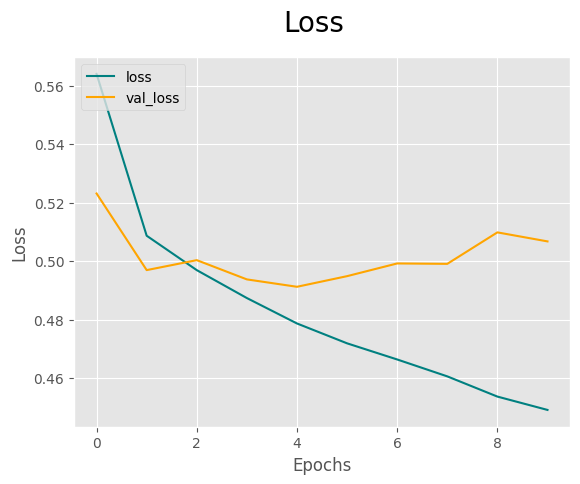

In [575]:

fig_loss = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig_loss.suptitle('Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

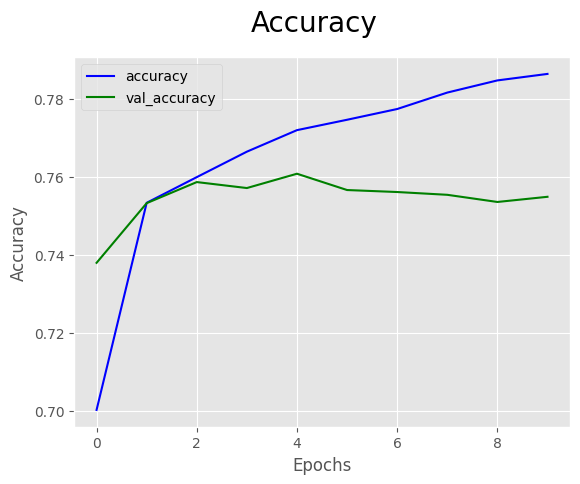

In [576]:

fig_accuracy = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color='green', label='val_accuracy')
fig_accuracy.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [577]:
eval = model.evaluate(X_test,Y_test)

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 155s 118ms/step - accuracy: 0.7517 - loss: 0.5084


In [578]:
print(eval)

[0.509433925151825, 0.7520952224731445]


In [579]:
model.save('model_d30000_b128_e7.keras')

In [580]:
Y_pred = model.predict(X_test) #getting predictions on the trained model

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 159s 121ms/step


In [581]:
print(Y_pred)

[[0.86565894]
 [0.7076525 ]
 [0.37013322]
 ...
 [0.72482765]
 [0.76382595]
 [0.72426444]]
